In [1]:
import blockmodel
md = blockmodel.Model()
md[2]

### Block information ###
# id: 2
# center_depth: 2800.5
# deepest: 2891.0
# shallowest: 2710.0
# center_radius: 3570.5
# top: 3661.0
# bottom: 3480.0
# latitude: 88.0
# north: 90.0
# south: 86.0
# longitude: -60.0
# west: -120.0
# east: 0.0
########################

In [2]:
foo = ['a','b','c']
for i, index in enumerate(foo):
    print(i, index)


0 a
1 b
2 c


/opt/homebrew/Caskroom/miniforge/base/envs/seqphase/lib/python3.10/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


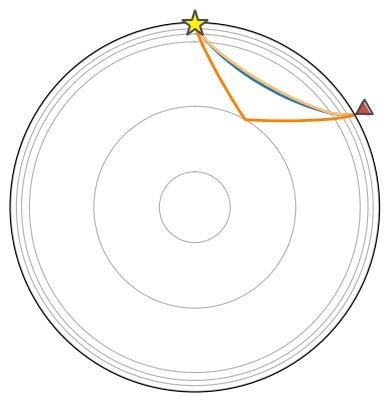

<PolarAxes: >

In [2]:
from obspy.taup import TauPyModel
velocity = TauPyModel(model="prem")
arrivals = velocity.get_ray_paths(50, 60, ('P', 'S', 'ScS'))
arrivals.plot_rays()

In [35]:
arrivals[0].incident_angle

27.380023638180212

In [ ]:
arrivals2 = velocity.get_travel_times(50, 30, ('P', 'S', 'ScS'))
arrivals2[0].distance

AttributeError: 'numpy.float64' object has no attribute 'get_travel_times'

In [113]:
from math import sin, radians, degrees
from obspy.geodetics import degrees2kilometers
path = arrivals[0].path
if True:
# def get_h(path):
    h = []
    for h_slowness, time, dist, depth_km in path:
        if time > 0:
            # h_slowness = 505.16561602
            time_increment = (time - time_previous)
            dist_increment = (dist - dist_previous)
            # dist_deg = 2.59000773e-01
            dist_increment_km = degrees2kilometers(degrees(dist_increment), 6371.-depth_km)
            # dist_increment_km = degrees(dist_increment) / .0125
            # velocity_km = dist_km / time_increment * 40
            velocity_kmps = dist_increment_km / time_increment
            sin_incident_angle = h_slowness * velocity_kmps
            h_dist_deg = dist_increment * sin_incident_angle
            h.append((velocity_kmps,depth_km))
            # h.append(h_dist_deg)
        time_previous = time
        dist_previous = dist
    # return h
# h=get_h(arrivals[-1].path)
# sum(h)

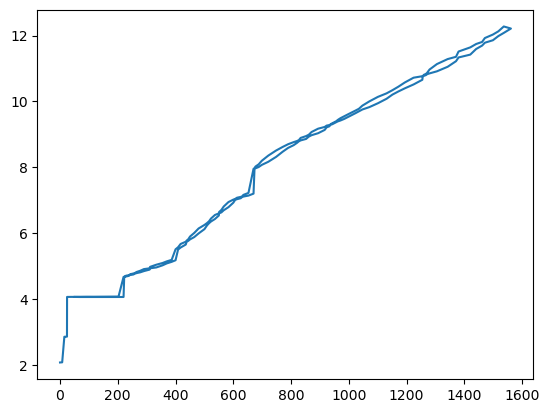

In [114]:
import matplotlib.pyplot as plt
vel = [hi[0] for hi in h]
dep = [hi[1] for hi in h]
plt.plot(dep,vel)

In [5]:
import numpy as np
dist = np.array([interval[2] for interval in arrivals[0].path])
sum(dist)

144.5367110844051

In [136]:
import numpy as np
import pyproj
from math import sin, radians, degrees, atan
from obspy.geodetics import kilometer2degrees,degrees2kilometers
def get_raypath_coordinates(lon1, lat1, lon2, lat2, source_depth_km, receiver_depth_km=0, phase_list=('P', 'S', 'ScS')):
    geod = pyproj.Geod(ellps="WGS84")
    velo = TauPyModel(model="prem")

    az, back_az, dist = geod.inv(lon1, lat1, lon2, lat2)
    distance_degree = kilometer2degrees(dist/1000)
    taup_arrivals = velo.get_ray_paths(source_depth_in_km=source_depth_km,
                                       distance_in_degree=distance_degree,
                                       phase_list=phase_list,
                                       receiver_depth_in_km=receiver_depth_km)
    print(f"{len(taup_arrivals)} rays calculated for {', '.join(phase_list)} with distance {round(distance_degree,4)} deg.")
    
    # return taup_arrivals
    results = []
    taup_paths = [taup_arrival.path for taup_arrival in taup_arrivals]
    for taup_path in taup_paths:
        taup_dists = np.array([degrees2kilometers(degrees(row[2]))*1000 for row in taup_path])
        taup_depths = np.array([row[3] for row in taup_path])
        # print(az)
        lons, lats, azs = geod.fwd(lon1*np.ones_like(taup_dists), lat1*np.ones_like(taup_dists), az*np.ones_like(taup_dists), taup_dists)
        dz = kilometer2degrees(np.diff(taup_depths))
        dx = np.diff([degrees(row[2]) for row in taup_path])
        # return dx,dz
        p = 1/(degrees(1/taup_path[0][0])) #s/rad to s/deg
        p = 1/degrees2kilometers(1/p, 6371-taup_depths[1:]) #s/deg to s/km
        slownesses = p / np.sin(np.arctan2(dx,dz))
        print(taup_path[0][0])
        slownesses = np.insert(slownesses,0,slownesses[0])
        results.append(np.array([lons, lats, taup_depths, slownesses]).T)
        
    return results
    # for p, time, dist, depth in taup_path:
    #     if dist > 0:
    #         lons, lats, az = geod.fwd(lons, lats, az, degrees2kilometers(degrees(dist))*1000, return_back_azimuth=False)
    #         print(lons, lats)
        # dist_previous = dist


# get_raypath_coordinates(np.array([50]),np.array([30]),0,60,arrivals[-1].path)
# lons, lats, azs, taup_depths = get_raypath_coordinates(0,0,60,0,arrivals[-1].path)
res = get_raypath_coordinates(139.7,35.7,-118.25,34.05,40)

# lons
# lats

3 rays calculated for P, S, ScS with distance 79.4365 deg.
310.5777761807111
604.077053066437
466.4982552593937


In [131]:
1/(degrees(1/310.5777761807111))

5.420604777875428

In [132]:
p = 1/(degrees(1/310.5777761807111))
p = 5.420604777875428 #s/deg
p = 1/degrees2kilometers(1/p) #km/s
p
# p / sin

0.04874866993889673

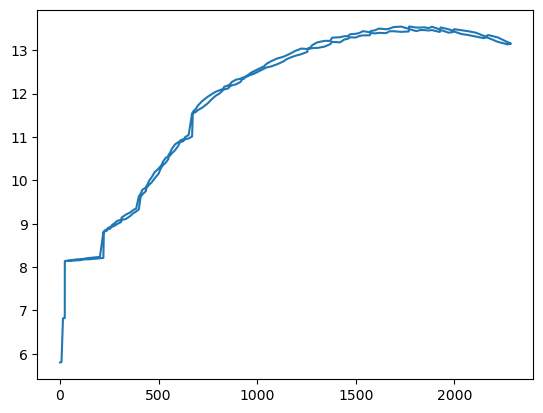

In [144]:
import matplotlib.pyplot as plt
z = res[0][:,2]
v = 1/res[0][:,3]
plt.plot(z,v)

In [ ]:
from math import cos, acos
def euclidean_distance(point1, point2):
    """
    Calculate the straight-line (chord) distance between two points inside the Earth,
    given their longitude, latitude (in degrees), and depth (in km).
    """
    # Get polar coordinates
    lon1_in_deg = point1[0]
    lat1_in_deg = point1[1]
    dep1_in_km = point1[2]
    lon2_in_deg = point2[0]
    lat2_in_deg = point2[1]
    dep2_in_km = point2[2]

    # Earth's mean radius in km
    R_earth = 6371.0

    # Convert to spherical coordinates (radius from center, theta, phi)
    r1 = R_earth - dep1_in_km
    r2 = R_earth - dep2_in_km

    # Convert degrees to radians
    lon1_rad = np.deg2rad(lon1_in_deg)
    lat1_rad = np.deg2rad(lat1_in_deg)
    lon2_rad = np.deg2rad(lon2_in_deg)
    lat2_rad = np.deg2rad(lat2_in_deg)

    # Spherical to Cartesian
    x1 = r1 * np.cos(lat1_rad) * np.cos(lon1_rad)
    y1 = r1 * np.cos(lat1_rad) * np.sin(lon1_rad)
    z1 = r1 * np.sin(lat1_rad)

    x2 = r2 * np.cos(lat2_rad) * np.cos(lon2_rad)
    y2 = r2 * np.cos(lat2_rad) * np.sin(lon2_rad)
    z2 = r2 * np.sin(lat2_rad)

    # Euclidean distance
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

def geod_midpoint(point1, point2):
    geod = pyproj.Geod(ellps="WGS84")
    az, back_az, dist = geod.inv(point1[0], point1[1], point2[0], point2[1])
    lon, lat, az = geod.fwd(point1[0], point1[1], az, dist/2)
    return np.array([lon, lat, (point1[2]+point2[2])/2, (point1[3]+point2[3])/2])

def get_kernel_from_raypath(md: blockmodel.Model, raypath):
    epsilon = 1e-6
    row_kernel = np.zeros_like(md)
    lon = lambda phi: (phi + 180) % 360 - 180
    lat = lambda psi: (180 - psi) if psi > 90 else (-180 - psi) if psi < -90 else psi
    i = 0
    while(i < len(raypath)-1):
        slowness = lambda pt: pt[3]
        block = lambda pt: md.findBlocks(readable=True,
                                        find_one=True,
                                        lon=float(pt[0]),
                                        lat=float(pt[1]),
                                        dep=max(float(pt[2]), epsilon),
                                        )
        this_point = raypath[i]
        next_point_idx = i+1
        next_point = raypath[next_point_idx]
        this_block = block(this_point)
        next_block = block(next_point)
        print(this_point, this_block.id, next_point, next_block.id, this_block == next_block)
        if this_block == next_block:
            row_kernel[this_block.id] -= euclidean_distance(this_point, next_point) * slowness(this_point)
            i += 1
        else:
            neighbor_blocks = md.findNeighbor(this_block, 'all')
            tmp_point = this_point
            while (not block(next_point) in neighbor_blocks):
                # mid_point = (tmp_point + next_point) / 2
                mid_point = geod_midpoint(tmp_point, next_point)
                print("find neighbors...", block(this_point).id, block(next_point).id, "@", mid_point)

                # if midpoint is neighbor, set as target point
                if block(mid_point) in neighbor_blocks:
                    next_point = mid_point
                    raypath = np.insert(raypath, i+1, mid_point, axis=0)
                    print("insert neighbor:", mid_point)

                # if midpoint and the working point belongs to the same block, move working point
                elif block(mid_point) == block(tmp_point):
                    tmp_point = mid_point

                # if midpoint and the target point belongs to the same block, move target point
                else:
                    next_point = mid_point
            
            # now the target point is truly a neighbor
            next_block = block(next_point)

            if i+1 == len(raypath):
                boundary_point = next_point
            else:
                point_by_ratio = lambda r: this_point + (next_point - this_point) * r
                if next_block in md.findNeighbor(this_block, 'E'):
                    boundary_point = point_by_ratio((lon(this_block.east) - this_point[0])/(next_point[0] - this_point[0]))
                    direction = [1, 0, 0, 0]
                elif next_block in md.findNeighbor(this_block, 'W'):
                    boundary_point = point_by_ratio((lon(this_block.west) - this_point[0])/(next_point[0] - this_point[0]))
                    direction = [-1, 0, 0, 0]
                elif next_block in md.findNeighbor(this_block, 'N'):
                    boundary_point = point_by_ratio((90-this_block.north - this_point[1])/(next_point[1] - this_point[1]))
                    direction = [0, 1, 0, 0]
                elif next_block in md.findNeighbor(this_block, 'S'):
                    boundary_point = point_by_ratio((90-this_block.south - this_point[1])/(next_point[1] - this_point[1]))
                    direction = [0, -1, 0, 0]
                elif next_block in md.findNeighbor(this_block, 'D'):
                    boundary_point = point_by_ratio((6371.-this_block.bottom - this_point[2])/(next_point[2] - this_point[2]))
                    direction = [0, 0, 1, 0]
                elif next_block in md.findNeighbor(this_block, 'U'):
                    boundary_point = point_by_ratio((6371.-this_block.top - this_point[2])/(next_point[2] - this_point[2]))
                    direction = [0, 0, -1, 0]
                
                print("neighbor:", direction)
                boundary_point_across = boundary_point + np.array(direction) * epsilon
                boundary_point_across[0] = lon(boundary_point_across[0])
                boundary_point_across[1] = lat(boundary_point_across[1])
                # print(6371.-this_block.bottom, this_point[2], next_point[2])
                # print((6371.-this_block.bottom - this_point[2])/(next_point[2] - this_point[2]))

            row_kernel[this_block.id] -= euclidean_distance(this_point, boundary_point) * slowness(this_point)
            print("insert:", boundary_point_across)
            raypath = np.insert(raypath, i+1, boundary_point_across, axis=0)
            i += 1
    
    return row_kernel
    # return md.findNeighbor(this_block, 'D') in md.findNeighbor(this_block, 'all')
    # print(midpoint)

kernel = get_kernel_from_raypath(md, res[-1])

In [147]:
kernel2 = []
for i, val in enumerate(kernel):
    if val != 0: 
        kernel2.append([md[i].clon-360 if md[i].clon>180 else md[i].clon, 90-md[i].clat, md[i].crad, val])
kernel2 = np.array(kernel2)

In [34]:
kernel2

array([[-1.77000000e+02,  4.80000000e+01,  4.16100000e+03,
        -1.95174075e+02],
       [-1.71000000e+02,  4.80000000e+01,  4.16100000e+03,
        -2.97186444e+02],
       [-1.65000000e+02,  4.80000000e+01,  4.16100000e+03,
        -2.99339329e+02],
       [-1.59000000e+02,  4.80000000e+01,  4.16100000e+03,
        -1.26353005e+02],
       [ 1.71000000e+02,  4.80000000e+01,  4.36100000e+03,
        -3.34659748e+02],
       [ 1.77000000e+02,  4.80000000e+01,  4.36100000e+03,
        -3.17614171e+02],
       [-1.77000000e+02,  4.80000000e+01,  4.36100000e+03,
        -1.07500540e+02],
       [-1.59000000e+02,  4.80000000e+01,  4.36100000e+03,
        -1.83099538e+02],
       [-1.53000000e+02,  4.80000000e+01,  4.36100000e+03,
        -3.28844775e+02],
       [-1.47000000e+02,  4.80000000e+01,  4.36100000e+03,
        -2.86282888e+01],
       [ 1.68923077e+02,  4.40000000e+01,  4.36100000e+03,
        -4.16715889e+01],
       [-1.46769231e+02,  4.40000000e+01,  4.36100000e+03,
      

In [7]:
(38 - 37.99651092)/(38.06824927 - 37.99651092)

0.04863618970886804

In [9]:
md.findBlocks(lon=-133.17936506, lat=41.36363406, dep=1509.95702611)

[### Block information ###
 # id: 15937
 # center_depth: 1410.0
 # deepest: 1510.0
 # shallowest: 1310.0
 # center_radius: 4961.0
 # top: 5061.0
 # bottom: 4861.0
 # latitude: 40.0
 # north: 42.0
 # south: 38.0
 # longitude: -133.04347826086956
 # west: -135.65217391304347
 # east: -130.43478260869566
 ########################]

In [20]:
md[28881]

### Block information ###
# id: 28881
# center_depth: 595.0
# deepest: 660.0
# shallowest: 530.0
# center_radius: 5776.0
# top: 5841.0
# bottom: 5711.0
# latitude: 36.0
# north: 38.0
# south: 34.0
# longitude: 140.54794520547946
# west: 138.08219178082194
# east: 143.013698630137
########################

In [8]:
90-md[26304].north

38.0

In [6]:
md[13359]

### Block information ###
# id: 13359
# center_depth: 1710.0
# deepest: 1910.0
# shallowest: 1510.0
# center_radius: 4661.0
# top: 4861.0
# bottom: 4461.0
# latitude: 40.0
# north: 42.0
# south: 38.0
# longitude: -133.04347826086956
# west: -135.65217391304347
# east: -130.43478260869566
########################

In [14]:
md.findNeighbor(md[15937], 'U')

[### Block information ###
 # id: 18515
 # center_depth: 1210.0
 # deepest: 1310.0
 # shallowest: 1110.0
 # center_radius: 5161.0
 # top: 5261.0
 # bottom: 5061.0
 # latitude: 40.0
 # north: 42.0
 # south: 38.0
 # longitude: -133.04347826086956
 # west: -135.65217391304347
 # east: -130.43478260869566
 ########################]

In [42]:
for line in res[1]:
    print(line)

[139.7  35.7  40. ]
[139.71591772  35.70891113  43.66540368]
[139.73369159  35.71885653  47.7533589 ]
[139.75147529  35.72880232  51.83844134]
[139.78707223  35.74869504  60.        ]
[139.8308474   35.77312994  70.00851713]
[139.87468375  35.79756795  80.        ]
[139.9132704   35.81905368  88.76927678]
[139.95190629  35.84054274  97.52568351]
[139.99059155  35.86203514 106.26924851]
[140.02932634  35.88353089 115.        ]
[140.07390263  35.90823844 125.0176845 ]
[140.11854737  35.93295186 135.01888585]
[140.18568883  35.97005815 150.        ]
[140.26464068  36.01359886 167.52470791]
[140.34381628  36.05716247 185.        ]
[140.42366699  36.10099572 202.52418381]
[140.50375567  36.14485704 220.        ]
[140.5176143   36.15243643 222.83173169]
[140.5315094   36.16003269 225.66588104]
[140.55940954  36.17527598 231.34144513]
[140.58745722  36.19058734 237.02671712]
[140.61565353  36.20596717 242.72172193]
[140.67100417  36.23612156 253.84225855]
[140.69889523  36.25129777 259.416467

## Output 3D curves for paraview

In [148]:
import pandas as pd

# Convert the first ray path result to a DataFrame and output as CSV
# Convert polar (longitude, latitude, depth) to cartesian (x, y, z) and normalize to [0,1]
from numpy import deg2rad, cos, sin

# Extract longitude, latitude, and depth from res[0]
lons = res[-1][:, 0]
lats = res[-1][:, 1]
depths = res[-1][:, 2]

# Assume Earth radius in km
R_earth = 6371.0

# Convert latitude and longitude to radians
lats_rad = deg2rad(lats)
lons_rad = deg2rad(lons)

# Compute radius at each depth (depth is in km)
r = R_earth - depths

# Convert to cartesian coordinates
x = r * cos(lats_rad) * cos(lons_rad)
y = r * cos(lats_rad) * sin(lons_rad)
z = r * sin(lats_rad)
# print(z.max(),z.min())

# Normalize x, y, z to [0,1] based on their min/max
x_norm = x / 2 / R_earth
y_norm = y / 2 / R_earth
z_norm = z / 2 / R_earth

df = pd.DataFrame(np.stack([x_norm, y_norm, z_norm], axis=1), columns=["x", "y", "z"])
df.to_csv("raypath_0.csv", index=False)
print(df.to_csv(index=False))

x,y,z
-0.30773091353586535,0.26097479332048895,0.289938738745533
-0.3075809014272832,0.26073895614564263,0.28981725558865556
-0.3074135714743901,0.26047594715835337,0.2896817381009062
-0.3072463334996218,0.26021313958786135,0.28954628461330484
-0.30691213311706017,0.259688127803635,0.28927556939916477
-0.3065021638283093,0.25904439517113254,0.28894342155237923
-0.30609273913777924,0.258401855072175,0.28861165264762706
-0.30573327137661993,0.25783799192510387,0.28832031438758104
-0.305374214069822,0.2572750278806845,0.2880292616632427
-0.30501556634475313,0.2567129608645023,0.287738493897183
-0.3046573273309606,0.25615178880825507,0.2874480105132435
-0.3042461396522791,0.25550798412902054,0.28711453567013573
-0.3038354760623086,0.25486532773116516,0.2867814253493966
-0.3032200443629849,0.25390283893086796,0.28628210377722063
-0.302499686605202,0.2527771784332918,0.28569748117520105
-0.3017808946148938,0.2516549496793612,0.28511394735751044
-0.30105962546542525,0.25052983196975925,0.2845

In [149]:
import pandas as pd

# Convert the first ray path result to a DataFrame and output as CSV
# Convert polar (longitude, latitude, depth) to cartesian (x, y, z) and normalize to [0,1]
from numpy import deg2rad, cos, sin

# Extract longitude, latitude, and depth from res[0]
lons = kernel2[:, 0]
lats = kernel2[:, 1]
r = kernel2[:, 2]
vals = kernel2[:, 3]

# Assume Earth radius in km
R_earth = 6371.0

# Convert latitude and longitude to radians
lats_rad = deg2rad(lats)
lons_rad = deg2rad(lons)

# Compute radius at each depth (depth is in km)
# r = R_earth - depths

# Convert to cartesian coordinates
x = r * cos(lats_rad) * cos(lons_rad)
y = r * cos(lats_rad) * sin(lons_rad)
z = r * sin(lats_rad)
# print(z.max(),z.min())

# Normalize x, y, z to [0,1] based on their min/max
x_norm = x / 2 / R_earth
y_norm = y / 2 / R_earth
z_norm = z / 2 / R_earth

df = pd.DataFrame(np.stack([x_norm, y_norm, z_norm, vals], axis=1), columns=["x", "y", "z", "val"])
df.to_csv("raypath_0_param.csv", index=False)
print(df.to_csv(index=False))

x,y,z,val
-0.18724349468176157,0.009813015741467057,0.20824035468270571,-13.691623175409074
-0.18724349468176157,-0.009813015741467057,0.20824035468270571,-35.12035441478382
-0.1851920157708079,-0.029331533770432135,0.20824035468270571,-34.187064022395276
-0.1811115343811485,-0.048528689377390306,0.20824035468270571,-34.59801109014768
-0.17504675712078413,-0.06719415450824857,0.20824035468270571,-36.30085066308161
-0.16706413095851552,-0.08512342642103375,0.20824035468270571,-4.3395746249037765
-0.19507272687691038,0.030896484668980605,0.21935078391308113,-33.500957795804005
-0.19723366013110358,0.010336578127337237,0.21935078391308113,-24.785322240017933
-0.17597764921859035,-0.08966509081907517,0.21935078391308113,-34.888862093561244
-0.1656410710912531,-0.10756856931202848,0.21935078391308113,-3.470214336651499
-0.1776029863152113,-0.11635640463603274,0.20503925061185754,-19.92291028621704
-0.20544617685707045,0.03253947773832283,0.2310152765433965,-7.052436158167589
-0.214278338045

In [177]:
depths

array([3.18550000e+08, 3.18597693e+08, 3.50440757e+08, 3.82260000e+08,
       4.46018041e+08, 5.09680000e+08, 5.95702847e+08, 6.81549364e+08,
       6.86384106e+08, 7.32665000e+08, 7.88524107e+08, 8.44307874e+08,
       9.55650000e+08, 1.06729467e+09, 1.17863500e+09, 1.29028148e+09,
       1.40162000e+09, 1.41581329e+09, 1.43002080e+09, 1.45847857e+09,
       1.51556568e+09, 1.53131376e+09, 1.54707928e+09, 1.61752255e+09,
       1.65287497e+09, 1.68831500e+09, 1.76944367e+09, 1.85103340e+09,
       1.97501000e+09, 1.98082383e+09, 1.98663999e+09, 2.12352168e+09,
       2.26170500e+09, 2.35443165e+09, 2.46253688e+09, 2.54840000e+09,
       2.60399059e+09, 2.66012750e+09, 2.77407281e+09, 2.79233972e+09,
       2.82952540e+09, 2.86695000e+09, 2.96131314e+09, 3.05721276e+09,
       3.18550000e+09, 3.24462328e+09, 3.28709983e+09, 3.32987658e+09,
       3.41634345e+09, 3.50405000e+09, 3.50791392e+09, 3.55926906e+09,
       3.61105390e+09, 3.71593445e+09, 3.82260000e+09, 3.86337010e+09,
      

In [142]:
from obspy.geodetics import kilometer2degrees
kilometer2degrees(taup_dists/1000)

array([0.00000000e+00, 5.28436496e-03, 2.87716386e-02, 5.76366139e-02,
       8.65216028e-02, 1.11930585e-01, 1.37356177e-01, 1.62798429e-01,
       1.88257391e-01, 2.17536093e-01, 2.46838643e-01, 2.90867191e-01,
       3.42579413e-01, 3.94371894e-01, 4.46538737e-01, 4.98793207e-01,
       5.07766526e-01, 5.16760546e-01, 5.34810957e-01, 5.52944976e-01,
       5.71163142e-01, 6.06891355e-01, 6.24877219e-01, 6.42944934e-01,
       6.79808363e-01, 6.98368292e-01, 7.17014427e-01, 7.53577577e-01,
       7.90473971e-01, 8.30948467e-01, 8.66291725e-01, 9.17449785e-01,
       9.41477694e-01, 9.73516659e-01, 1.00580290e+00, 1.05068925e+00,
       1.09605698e+00, 1.12183900e+00, 1.14803136e+00, 1.19131051e+00,
       1.23572709e+00, 1.25837479e+00, 1.28132241e+00, 1.33753908e+00,
       1.39558595e+00, 1.43552551e+00, 1.47634868e+00, 1.53357098e+00,
       1.58167401e+00, 1.58688552e+00, 1.60439395e+00, 1.60523859e+00,
       1.60608359e+00, 1.60777470e+00, 1.61116130e+00, 1.61795215e+00,
      